In [1]:
from os.path import join, dirname, expanduser
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines
from matplotlib.patches import Rectangle

from scipy import optimize, stats

# from nilearn import image, plotting, masking
# from nilearn.maskers import NiftiLabelsMasker

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.decomposition import PCA
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.preprocessing import StandardScaler

# from tqdm import tqdm

# import pingouin as pg

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')
dir_home = expanduser('~')
# dir_home = 'D:/'

In [4]:
img_bg = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

In [5]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55', '71', '72', '73', '74'
    , '75'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [6]:
list_run = ['r%02d'%(rr+1) for rr in range(3)]
list_group = ['no_stim','DLPFC_cTBS','M1_cTBS','DLPFC_20Hz']
list_roi = ['LaCA','LpCA','RaCA','RpCA','LaPU','LpPU','RaPU','RpPU']

---

## Import the result

In [7]:
# df = pd.read_excel('./KJH/LME/data/Rew#1_Coef_GPn50_KJH.xlsx')
# df['stim'] = ['yes' if subj[1]!='A' else 'no' for subj in df.subj]
# df.time += 1
# df

In [8]:
df = pd.read_excel(join(dir_home,'Github/labs/GP/results/performance_modulated_activity.8_striatum.xlsx'))
df['time'] = [1 if run=='r01' else (2 if run=='r02' else (3 if run=='r03' else 0)) for run in df.run]
df['striatum'] = ['caudate' if roi[2:]=='CA' else ('putamen' if roi[2:]=='PU' else 'invalid') for roi in df.roi]
df['LR'] = [roi[0] for roi in df.roi]
df['AP'] = [roi[1] for roi in df.roi]
df

,subj,group,run,roi,beta,nvoxels,time,striatum,LR,AP
0,GA01,no_stim,r01,RaPU,0.518611,135,1,putamen,R,a
1,GA01,no_stim,r01,LaPU,0.599993,133,1,putamen,L,a
2,GA01,no_stim,r01,LpPU,0.151185,132,1,putamen,L,p
3,GA01,no_stim,r01,RpPU,0.272298,105,1,putamen,R,p
4,GA01,no_stim,r01,LaCA,0.538827,71,1,caudate,L,a
...,...,...,...,...,...,...,...,...,...,...
1915,GP75,DLPFC_20Hz,r03,RpPU,0.614432,105,3,putamen,R,p
1916,GP75,DLPFC_20Hz,r03,LaCA,0.917109,71,3,caudate,L,a
1917,GP75,DLPFC_20Hz,r03,LpCA,0.538714,103,3,caudate,L,p
1918,GP75,DLPFC_20Hz,r03,RaCA,1.086447,66,3,caudate,R,a


---

## Make LME datafram

1. beta ~ time*C(group, Treatment('%s'))

In [9]:
group_ref = 'no_stim'

In [10]:
df_LME = pd.DataFrame()
for roi in list_roi:    
    for ii, group_ref in enumerate(list_group):
        df_tmp = df[df['roi']==roi]
        model = smf.mixedlm(
            "beta ~ time*C(group, Treatment('%s'))"%group_ref,
            df_tmp,
            groups=df_tmp['subj']
        )
        result = model.fit()
        # print(result.summary())
        for jj, group in enumerate(list_group[ii+1:]):
            new_row = pd.Series(
                {
                    'roi':roi, 'group_ref':group_ref, 'group':group,
                    # 'Intercept':result.params.Intercept + result.params["C(group, Treatment('%s'))[T.%s]"%(group_ref,group)],
                    'Intercept':result.params["C(group, Treatment('%s'))[T.%s]"%(group_ref,group)],
                    # 'Slope':result.params.time + result.params["time:C(group, Treatment('%s'))[T.%s]"%(group_ref,group)],
                    'Slope':result.params["time:C(group, Treatment('%s'))[T.%s]"%(group_ref,group)],
                    'SE_Intercept':result.bse_fe["C(group, Treatment('%s'))[T.%s]"%(group_ref,group)],
                    'SE_Slope':result.bse_fe["time:C(group, Treatment('%s'))[T.%s]"%(group_ref,group)],
                    'pval_Intercept':result.pvalues["C(group, Treatment('%s'))[T.%s]"%(group_ref,group)],
                    'pval_Slope':result.pvalues["time:C(group, Treatment('%s'))[T.%s]"%(group_ref,group)]
                }
            )
            df_LME = pd.concat(
                [df_LME, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
df_LME

,roi,group_ref,group,Intercept,Slope,SE_Intercept,SE_Slope,pval_Intercept,pval_Slope
0,LaCA,no_stim,DLPFC_cTBS,0.296152,-0.177475,0.128811,0.047896,0.021498,0.000211
1,LaCA,no_stim,M1_cTBS,0.033877,0.012246,0.128811,0.047896,0.792552,0.798191
2,LaCA,no_stim,DLPFC_20Hz,-0.072512,0.039792,0.131355,0.048842,0.580926,0.415245
3,LaCA,DLPFC_cTBS,M1_cTBS,-0.262275,0.189722,0.145539,0.054116,0.07153,0.000455
4,LaCA,DLPFC_cTBS,DLPFC_20Hz,-0.368664,0.217267,0.147795,0.054955,0.012616,0.000077
5,LaCA,M1_cTBS,DLPFC_20Hz,-0.106389,0.027545,0.147795,0.054955,0.471623,0.61621
6,LpCA,no_stim,DLPFC_cTBS,0.126062,-0.089273,0.138693,0.05158,0.363386,0.083495
7,LpCA,no_stim,M1_cTBS,-0.078917,0.061624,0.138693,0.05158,0.569352,0.232198
8,LpCA,no_stim,DLPFC_20Hz,-0.174191,0.108495,0.141432,0.052599,0.21809,0.039144
9,LpCA,DLPFC_cTBS,M1_cTBS,-0.204979,0.150897,0.156704,0.058279,0.190851,0.009619


---

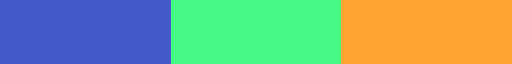

In [11]:
tmp = cm.turbo(np.linspace(0.1,1.0,4))
palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp][:-1]

colors.ListedColormap(palette)

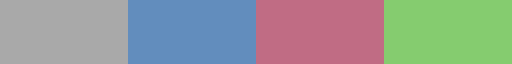

In [12]:
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']
cmap = colors.ListedColormap(palette)
cmap

---

## Fig. 3

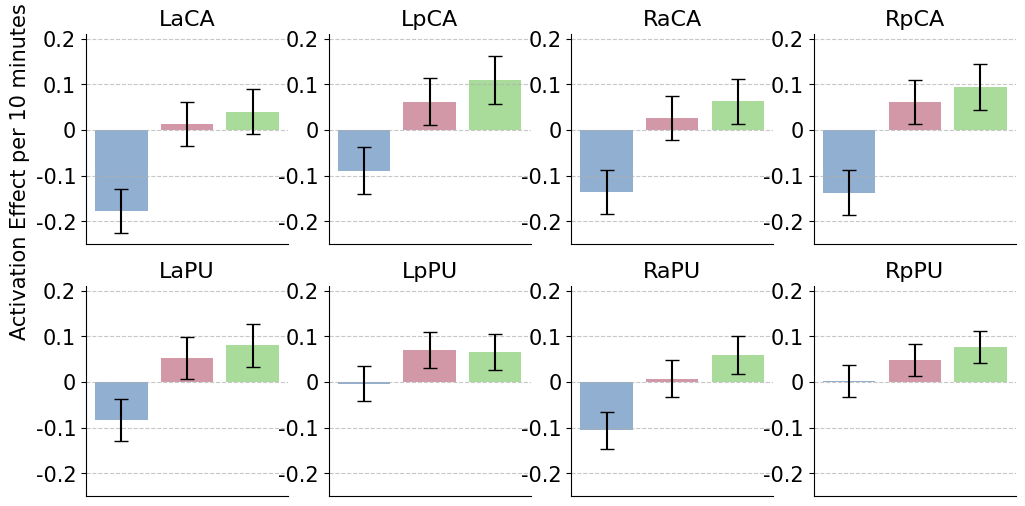

In [48]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
axs = np.reshape(axs, -1)

for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    df_tmp = df_LME[(df_LME.roi==roi)&(df_LME.group_ref=='no_stim')]

    ## plotting figure
    ax.set_title('%s'%roi, fontsize=16)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.bar(
        [0,1,2],
        df_tmp.Slope, yerr=df_tmp.SE_Slope,
        capsize=5,
        color=palette[1:], alpha=0.7,
    )
    if ii == 0:
        ax.set_ylabel('Activation Effect per 10 minutes (A.U.)', fontsize=15)
        
    ax.set_ylim([-0.25,0.21])
    yticks=[-0.2, -0.1, 0, 0.1, 0.2]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=15)
    # ax.set_xticks([0, 1, 2])
    # ax.set_xticklabels(['', '', ''], fontsize=0)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False  # labels along the bottom edge are off
    )

In [49]:
n_Bonferroni = len(list_roi)
n_Bonferroni

8

(LaCA) DLPFC_cTBS: p = ***2.110e-04 / corrected p = **1.688e-03
(LaCA) M1_cTBS: p = ns7.982e-01 / corrected p = ns6.386e+00
(LaCA) DLPFC_20Hz: p = ns4.152e-01 / corrected p = ns3.322e+00

(LpCA) DLPFC_cTBS: p = ns8.350e-02 / corrected p = ns6.680e-01
(LpCA) M1_cTBS: p = ns2.322e-01 / corrected p = ns1.858e+00
(LpCA) DLPFC_20Hz: p = *3.914e-02 / corrected p = ns3.132e-01

(RaCA) DLPFC_cTBS: p = **4.702e-03 / corrected p = *3.762e-02
(RaCA) M1_cTBS: p = ns5.894e-01 / corrected p = ns4.715e+00
(RaCA) DLPFC_20Hz: p = ns2.041e-01 / corrected p = ns1.633e+00

(RpCA) DLPFC_cTBS: p = **4.864e-03 / corrected p = *3.891e-02
(RpCA) M1_cTBS: p = ns2.109e-01 / corrected p = ns1.687e+00
(RpCA) DLPFC_20Hz: p = ns5.841e-02 / corrected p = ns4.673e-01

(LaPU) DLPFC_cTBS: p = ns7.033e-02 / corrected p = ns5.626e-01
(LaPU) M1_cTBS: p = ns2.545e-01 / corrected p = ns2.036e+00
(LaPU) DLPFC_20Hz: p = ns8.703e-02 / corrected p = ns6.963e-01

(LpPU) DLPFC_cTBS: p = ns9.219e-01 / corrected p = ns7.375e+00
(LpP

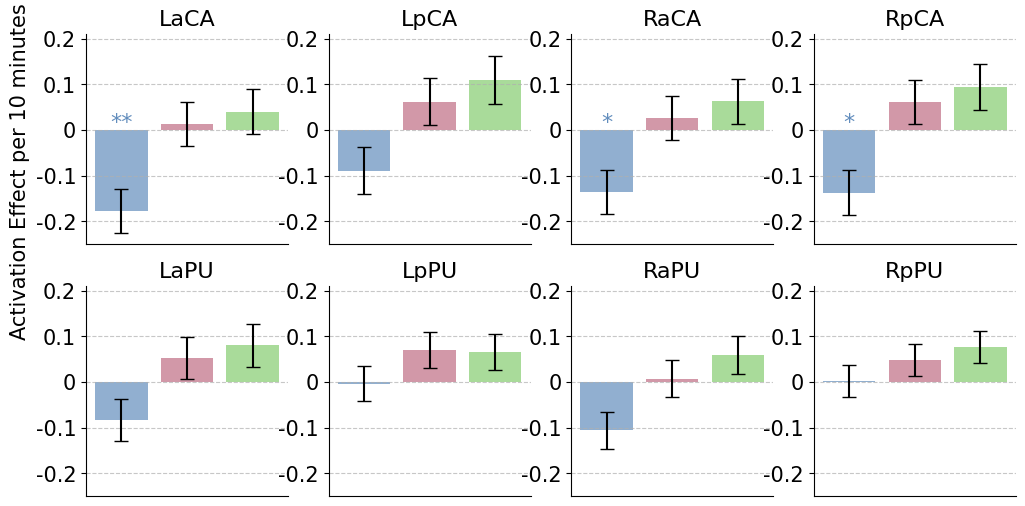

In [50]:
for kk, roi in enumerate(list_roi):
    ax = axs[kk]
    for ii, group in enumerate(list_group[1:]):
        df_tmp = df_LME[(df_LME.roi==roi)&(df_LME.group_ref=='no_stim')]
        pval = df_tmp[df_tmp.group==group].pval_Slope.values[0]
        pval_c = pval * n_Bonferroni
        mean = df_tmp[df_tmp.group==group].Slope.values[0]
        se = df_tmp[df_tmp.group==group].SE_Slope.values[0]
        print('(%s) %s: p = %s%.3e / corrected p = %s%.3e'%(roi,group,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c))
        if pval_c < 0.05:
            if group == 'DLPFC_cTBS':
                y = max(mean+se,0) + 0.015
            else:
                y = min(mean-se,0) - 0.035
            ax.text(
                ii, y,
                convert_pvalue_to_asterisks(pval_c),
                fontsize=16, color=cmap(ii+1),
                horizontalalignment='center', verticalalignment='center'
            )
            # ax.text(
            #     jj_, 0.1+0.05*(jj+1),
            #     '%.3f-%.3f'%(y,se),
            #     horizontalalignment='center', verticalalignment='center'
            # )
    print('')
fig

/tmp/ipykernel_551605/1613398458.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


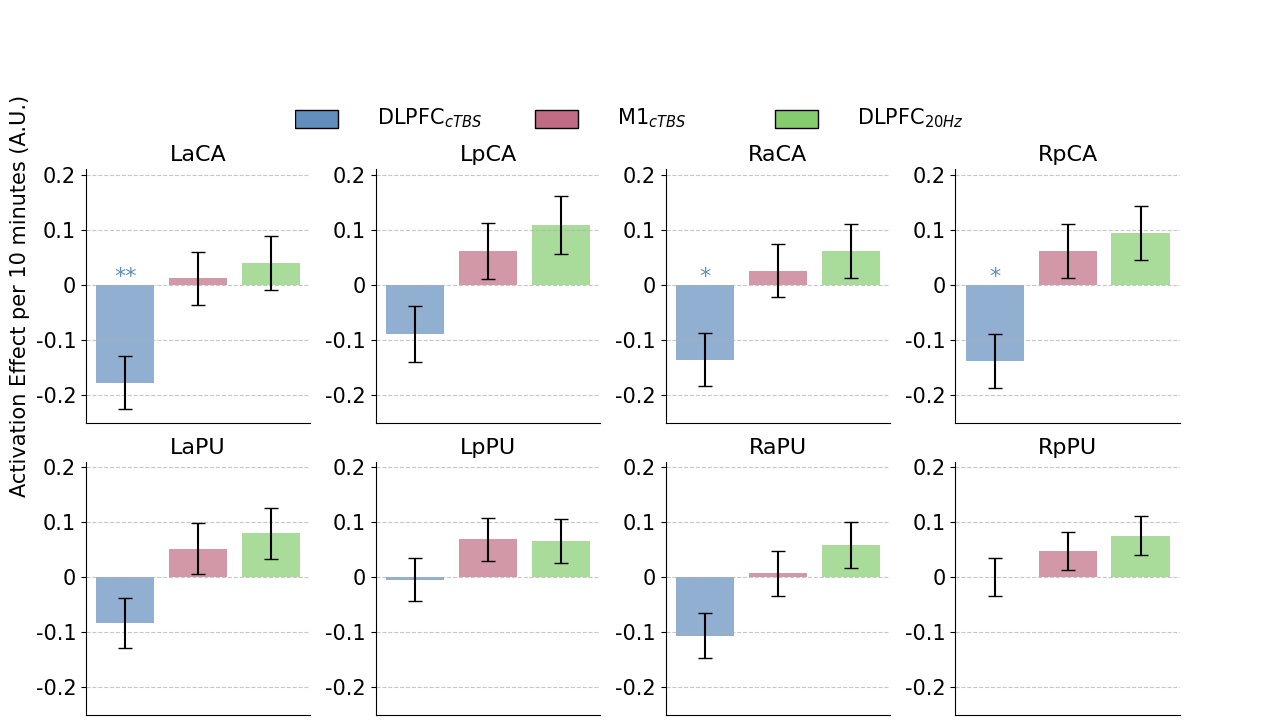

In [47]:
### legend
nax = fig.add_axes([0.25, 1, .8, 0.2])

for ii, group in enumerate(list_group[1:]):
    if group == 'DLPFC_cTBS':
        gg = 'DLPFC$_{cTBS}$'
    elif group == 'M1_cTBS':
        gg = 'M1$_{cTBS}$'
    elif group == 'DLPFC_20Hz':
        gg = 'DLPFC$_{20Hz}$'
        
    rgb = cmap(ii+1)
    dx = 0.25*ii
    x, y = 0 + dx, 0.02
    w, h = 0.045, 0.15
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.085, 0, gg, fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    
nax.axis('off')
fig.tight_layout()
fig

In [43]:
fig.savefig(
    join(dir_home, 'Github/labs/GP/results/fig.3ii.png')
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

2. beta ~ time*C(group, Treatment('%s'))*C(ROI, Treatment('%s'))

In [40]:
model = smf.mixedlm(
    "beta ~ time*C(group, Treatment('%s'))*C(striatum, Treatment('%s'))"%('no_stim','caudate'),
    df,
    groups=df['subj']
)
result = model.fit()
print(result.summary())

                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                            Dependent Variable:                            beta     
No. Observations:                             1920                               Method:                                        REML     
No. Groups:                                   80                                 Scale:                                         0.0555   
Min. group size:                              24                                 Log-Likelihood:                                -113.2101
Max. group size:                              24                                 Converged:                                     Yes      
Mean group size:                              24.0                                                                                       
------------------------------------------------------------------------------------

In [126]:
for striatum in ['caudate','putamen']:
    print('*%s*'%striatum)
    df_tmp = df[df.striatum==striatum]

    ## LR
    print('*LR')
    model = smf.mixedlm(
        "beta ~ time*C(group, Treatment('%s'))*C(LR, Treatment('%s'))"%('no_stim','L'),
        df_tmp,
        groups=df_tmp['subj']
    )
    result = model.fit()
    for idx in result.fe_params.index:
        pval = result.pvalues[idx]
        if pval < 0.05:
            print('%s: %s%.3e'%(idx,convert_pvalue_to_asterisks(pval),pval))
        
    print(result.summary())

    ## AP
    print('*AP')
    model = smf.mixedlm(
        "beta ~ time*C(group, Treatment('%s'))*C(AP, Treatment('%s'))"%('no_stim','a'),
        df_tmp,
        groups=df_tmp['subj']
    )
    result = model.fit()
    for idx in result.fe_params.index:
        pval = result.pvalues[idx]
        if pval < 0.05:
            print('%s: %s%.3e'%(idx,convert_pvalue_to_asterisks(pval),pval))
    print(result.summary())

*caudate*
*LR
Intercept: ****6.427e-15
time: ****4.833e-09
time:C(group, Treatment('no_stim'))[T.DLPFC_20Hz]: *3.779e-02
time:C(group, Treatment('no_stim'))[T.DLPFC_cTBS]: ***1.388e-04
                                         Mixed Linear Model Regression Results
Model:                                   MixedLM                      Dependent Variable:                      beta    
No. Observations:                        960                          Method:                                  REML    
No. Groups:                              80                           Scale:                                   0.0532  
Min. group size:                         12                           Log-Likelihood:                          -98.9334
Max. group size:                         12                           Converged:                               Yes     
Mean group size:                         12.0                                                                          
----------------